In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
!pip install thop


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 5.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 103.5 MB/s eta 0:00:0000:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 78.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 34.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 32.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 14.4 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 2.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 97.0 MB/s eta 0:00:00:00:0100:01
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5

In [2]:
import os, random, warnings, copy
import numpy as np
import pandas as pd
from collections import Counter

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, label_binarize
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from sklearn.metrics import matthews_corrcoef, roc_auc_score, roc_curve
from statsmodels.stats.contingency_tables import mcnemar

from thop import profile
import matplotlib.pyplot as plt

warnings.filterwarnings("ignore")
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", DEVICE)

# ===================
# GLOBAL SETTINGS
# ===================
SEEDS = [1,2,3,4,5]
BATCH = 32
EPOCHS = 30
PATIENCE = 5
MAX_LEN = 300
K = 6

DATASETS = {
    "chimpanzee": "/kaggle/input/dna-sequence-dataset/chimpanzee.txt",
    "human": "/kaggle/input/dna-sequence-dataset/human.txt",
    "dog": "/kaggle/input/dna-sequence-dataset/dog.txt"
}

MODEL_DIR = "saved_models"
os.makedirs(MODEL_DIR, exist_ok=True)


Device: cuda


In [3]:
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False


In [4]:
def load_dataset(name):
    df = pd.read_csv(DATASETS[name], sep="\t").dropna()
    enc = LabelEncoder()
    df["label"] = enc.fit_transform(df["class"])
    print(f"{name.upper()} | {len(df)} samples | {len(enc.classes_)} classes")
    return df, enc


In [5]:
def kmers(seq, k):
    return [seq[i:i+k].lower() for i in range(len(seq)-k+1)]

def build_vocab(seqs):
    all_k = []
    for s in seqs:
        all_k.extend(kmers(s, K))
    return {k:i+1 for i,(k,_) in enumerate(Counter(all_k).most_common())}

def encode_kmer(seq, vocab):
    return [vocab[k] for k in kmers(seq, K) if k in vocab]

def pad_kmer(seqs):
    out = np.zeros((len(seqs), MAX_LEN), dtype=np.int64)
    for i,s in enumerate(seqs):
        out[i,:len(s[:MAX_LEN])] = s[:MAX_LEN]
    return out


In [6]:
class KmerDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.long)
        self.y = torch.tensor(y, dtype=torch.long)

    def __len__(self): 
        return len(self.X)

    def __getitem__(self, i): 
        return self.X[i], self.y[i]


In [7]:
class CNN(nn.Module):
    def __init__(self,vocab_size,num_classes,embed_dim=128,num_filters=256,kernel_sizes=(3,5,7),dropout=0.4):
        super().__init__()
        self.embed = nn.Embedding(vocab_size, embed_dim)
        self.convs = nn.ModuleList([nn.Conv1d(embed_dim, num_filters, k, padding=k//2) for k in kernel_sizes])
        self.drop = nn.Dropout(dropout)
        self.fc = nn.Linear(num_filters * len(kernel_sizes), num_classes)

    def forward(self,x):
        x = self.embed(x)                 # (B,T,E)
        x = x.transpose(1,2)              # (B,E,T)
        h = [F.max_pool1d(F.relu(c(x)), x.shape[2]).squeeze(2) for c in self.convs]
        return self.fc(self.drop(torch.cat(h,1)))


In [8]:
class CNNAttention(nn.Module):
    def __init__(self,vocab_size,num_classes,embed_dim=128,conv_filters=256,conv_kernel=11,n_heads=4,dropout=0.4):
        super().__init__()
        self.embed = nn.Embedding(vocab_size, embed_dim)
        self.conv = nn.Conv1d(embed_dim,conv_filters,conv_kernel,padding=conv_kernel//2)
        self.proj = nn.Linear(conv_filters,embed_dim)
        self.attn = nn.MultiheadAttention(embed_dim,n_heads,batch_first=True)
        self.drop = nn.Dropout(dropout)
        self.fc = nn.Linear(embed_dim,num_classes)

    def forward(self,x):
        x = self.embed(x)                 # (B,T,E)
        x = F.relu(self.conv(x.transpose(1,2))).transpose(1,2)
        x = self.proj(x)
        a,_ = self.attn(x,x,x)
        return self.fc(self.drop(a.mean(1)))


In [9]:
class CNNBiLSTM(nn.Module):
    def __init__(self,vocab_size,num_classes,embed_dim=128,conv_filters=256,lstm_hidden=256,dropout=0.3):
        super().__init__()
        self.embed = nn.Embedding(vocab_size, embed_dim)
        self.conv = nn.Conv1d(embed_dim,conv_filters,7,padding=3)
        self.lstm = nn.LSTM(conv_filters,lstm_hidden,batch_first=True,bidirectional=True)
        self.drop = nn.Dropout(dropout)
        self.fc = nn.Linear(lstm_hidden * 2,num_classes)

    def forward(self,x):
        x = self.embed(x)
        x = F.relu(self.conv(x.transpose(1,2))).transpose(1,2)
        h,_ = self.lstm(x)
        h,_ = torch.max(h,1)
        return self.fc(self.drop(h))


In [10]:
MODEL_CONFIGS = {
    "CNN": [
        dict(embed_dim=128,num_filters=128,kernel_sizes=(3,5,7)),
        dict(embed_dim=128,num_filters=256,kernel_sizes=(5,7,9)),
        dict(embed_dim=256,num_filters=256,kernel_sizes=(3,5,7))
    ],
    "CNN-Attention": [
        dict(embed_dim=128,conv_filters=128,conv_kernel=7,n_heads=2),
        dict(embed_dim=128,conv_filters=256,conv_kernel=11,n_heads=4),
        dict(embed_dim=256,conv_filters=256,conv_kernel=15,n_heads=4)
    ],
    "CNN-BiLSTM": [
        dict(embed_dim=128,conv_filters=128,lstm_hidden=128),
        dict(embed_dim=128,conv_filters=256,lstm_hidden=256),
        dict(embed_dim=256,conv_filters=256,lstm_hidden=512)
    ]
}


In [11]:
def compute_metrics(y,p):
    pred = p.argmax(1)
    acc = accuracy_score(y,pred)
    prec,rec,f1,_ = precision_recall_fscore_support(y,pred,average="macro",zero_division=0)
    mcc = matthews_corrcoef(y,pred)
    yb = label_binarize(y, classes=np.arange(len(np.unique(y))))
    auc = roc_auc_score(yb,p,average="macro",multi_class="ovr")
    return dict(acc=acc,prec=prec,recall=rec,f1=f1,mcc=mcc,auc=auc)

def train_eval(model,tr,te):
    model.to(DEVICE)
    opt = torch.optim.Adam(model.parameters(),1e-3)
    loss_fn = nn.CrossEntropyLoss()

    best=-1; bad=0; best_state=None

    for _ in range(EPOCHS):
        model.train()
        for x,y in tr:
            opt.zero_grad()
            loss = loss_fn(model(x.to(DEVICE)),y.to(DEVICE))
            loss.backward()
            opt.step()

        model.eval()
        P=[]; Y=[]
        with torch.no_grad():
            for x,y in te:
                P.append(torch.softmax(model(x.to(DEVICE)),1).cpu().numpy())
                Y.append(y.numpy())

        P=np.vstack(P); Y=np.concatenate(Y)
        m=compute_metrics(Y,P)

        if m["mcc"]>best:
            best=m["mcc"]
            bad=0
            best_state=copy.deepcopy(model.state_dict())
        else:
            bad+=1
            if bad>=PATIENCE:
                break

    model.load_state_dict(best_state)

    P=[]; Y=[]
    with torch.no_grad():
        for x,y in te:
            P.append(torch.softmax(model(x.to(DEVICE)),1).cpu().numpy())
            Y.append(y.numpy())

    return compute_metrics(np.concatenate(Y),np.vstack(P)), np.vstack(P), np.concatenate(Y), model


In [12]:
def run_pipeline(dataset_name):

    print("\n" + "="*60)
    print(f"DATASET: {dataset_name.upper()} | ENCODING: KMER")
    print("="*60)

    df,_ = load_dataset(dataset_name)
    X_raw = df["sequence"].values
    y = df["label"].values
    NUM_CLASSES = len(np.unique(y))

    vocab = build_vocab(X_raw)
    X = pad_kmer([encode_kmer(s,vocab) for s in X_raw])

    dummy = torch.zeros((1,MAX_LEN),dtype=torch.long).to(DEVICE)

    def loaders(seed):
        set_seed(seed)
        Xtr,Xte,ytr,yte = train_test_split(X,y,test_size=0.2,stratify=y,random_state=seed)
        return DataLoader(KmerDataset(Xtr,ytr),BATCH,True), DataLoader(KmerDataset(Xte,yte),BATCH)

    BEST_CFG = {}; RESULTS={}; PRED_STORE={}


    # =================
    # STAGE 1 — TUNING
    # =================
    print("\n== STAGE 1: CONFIG SEARCH ==")
    tr0, te0 = loaders(42)

    for name, configs in MODEL_CONFIGS.items():

        print(f"\n{name} CONFIG RESULTS")
        best = None

        for i,cfg in enumerate(configs,1):

            model = (
                CNN if name=="CNN" else
                CNNAttention if name=="CNN-Attention" else
                CNNBiLSTM
            )(len(vocab)+1, NUM_CLASSES, **cfg).to(DEVICE)

            met,_,_,_ = train_eval(model,tr0,te0)

            print(f"{name} CONFIG {i} ->", met)

            if best is None or met["mcc"] > best[1]["mcc"]:
                best=(cfg,met)

        BEST_CFG[name]=best[0]

    # ======================
    # STAGE 2 — ROBUSTNESS
    # ======================
    print("\n== STAGE 2: ROBUSTNESS ==")

    for name,cfg in BEST_CFG.items():
        print(f"\n{name} BEST CONFIG:", cfg)

        scores=[]; preds=[]

        for seed in SEEDS:
            tr,te = loaders(seed)

            model = (
                CNN if name=="CNN" else
                CNNAttention if name=="CNN-Attention" else
                CNNBiLSTM
            )(len(vocab)+1, NUM_CLASSES, **cfg)

            met,P,Y,model = train_eval(model,tr,te)
            scores.append(met)
            preds.append((P.argmax(1),Y))

        RESULTS[name]=scores
        PRED_STORE[name]=preds

        save_path=f"{MODEL_DIR}/{dataset_name}_kmer_{name}.pt"
        torch.save(model.state_dict(),save_path)
        print("Saved:",save_path)

        arr=lambda k: np.array([s[k] for s in scores])

        print(f"{name} MEAN±STD | "
              f"ACC {arr('acc').mean():.4f}±{arr('acc').std():.4f} | "
              f"PREC {arr('prec').mean():.4f}±{arr('prec').std():.4f} | "
              f"REC {arr('recall').mean():.4f}±{arr('recall').std():.4f} | "
              f"F1 {arr('f1').mean():.4f}±{arr('f1').std():.4f} | "
              f"MCC {arr('mcc').mean():.4f}±{arr('mcc').std():.4f} | "
              f"AUC {arr('auc').mean():.4f}±{arr('auc').std():.4f}")


    # ======================
    # COMPLEXITY (THOP)
    # ======================
    print("\n== MODEL COMPLEXITY (THOP) ==")

    for name,cfg in BEST_CFG.items():

        model = (
            CNN if name=="CNN" else
            CNNAttention if name=="CNN-Attention" else
            CNNBiLSTM
        )(len(vocab)+1, NUM_CLASSES, **cfg).to(DEVICE)

        flops, params = profile(model, inputs=(dummy,), verbose=False)

        print(f"{name} | Params: {params:,} | GFLOPs: {flops/1e9:.4f}")


    # ======================
    # STAGE 3 — BEST MODEL
    # ======================
    MEANS = {k:np.mean([v["mcc"] for v in s]) for k,s in RESULTS.items()}
    BEST = max(MEANS, key=MEANS.get)

    print("\n🏆 FINAL BEST MODEL:", BEST)


    # ======================
    # STAGE 4 — MCNEMAR
    # ======================
    print("\n== STAGE 4: MCNEMAR ==")

    base = np.concatenate([p==y for p,y in PRED_STORE[BEST]])

    for name,data in PRED_STORE.items():
        if name==BEST: continue

        oth = np.concatenate([p==y for p,y in data])

        table=[[np.sum(base & oth), np.sum(base & ~oth)],
               [np.sum(~base & oth), np.sum(~base & ~oth)]]

        print(BEST,"vs",name,"p-value:",mcnemar(table,exact=True).pvalue)


    # ======================
    # STAGE 5 — ROC
    # ======================
    print("\n== STAGE 5: ROC ==")

    fpr_grid=np.linspace(0,1,200)
    tprs=[]

    for seed in SEEDS:
        tr,te = loaders(seed)

        model = (
            CNN if BEST=="CNN" else
            CNNAttention if BEST=="CNN-Attention" else
            CNNBiLSTM
        )(len(vocab)+1, NUM_CLASSES, **BEST_CFG[BEST])

        _,probs,ytrue,_ = train_eval(model,tr,te)

        yb=label_binarize(ytrue,classes=np.arange(NUM_CLASSES))

        per=[]
        for c in range(NUM_CLASSES):
            fpr,tpr,_=roc_curve(yb[:,c],probs[:,c])
            per.append(np.interp(fpr_grid,fpr,tpr))

        tprs.append(np.mean(per,0))

    mean=np.mean(tprs,0)
    auc=np.trapz(mean,fpr_grid)

    plt.figure(figsize=(6,5))
    plt.plot(fpr_grid,mean,label=f"AUC={auc:.3f}")
    plt.plot([0,1],[0,1],'k--')
    plt.title(f"AUC–ROC (Best Model: {BEST} | {dataset_name.upper()})")
    plt.xlabel("FPR"); plt.ylabel("TPR")
    plt.legend(); plt.show()



DATASET: CHIMPANZEE | ENCODING: KMER
CHIMPANZEE | 1682 samples | 7 classes

== STAGE 1: CONFIG SEARCH ==

CNN CONFIG RESULTS
CNN CONFIG 1 -> {'acc': 0.8189910979228486, 'prec': 0.8641106709900328, 'recall': 0.783920598188996, 'f1': 0.8083718406022292, 'mcc': 0.779826506528276, 'auc': 0.9671344410113194}
CNN CONFIG 2 -> {'acc': 0.8308605341246291, 'prec': 0.9183567679945541, 'recall': 0.7846108662083653, 'f1': 0.833655783890397, 'mcc': 0.7968699955247596, 'auc': 0.9740511629095013}
CNN CONFIG 3 -> {'acc': 0.8249258160237388, 'prec': 0.8898407251853894, 'recall': 0.7872433417107888, 'f1': 0.8265789638850963, 'mcc': 0.7864017072931786, 'auc': 0.9712024540029267}

CNN-Attention CONFIG RESULTS
CNN-Attention CONFIG 1 -> {'acc': 0.7418397626112759, 'prec': 0.7351707644448878, 'recall': 0.698584226747007, 'f1': 0.7128186500310997, 'mcc': 0.6829553485285665, 'auc': 0.9255145925720398}
CNN-Attention CONFIG 2 -> {'acc': 0.7537091988130564, 'prec': 0.7713898429491761, 'recall': 0.7085305843320453

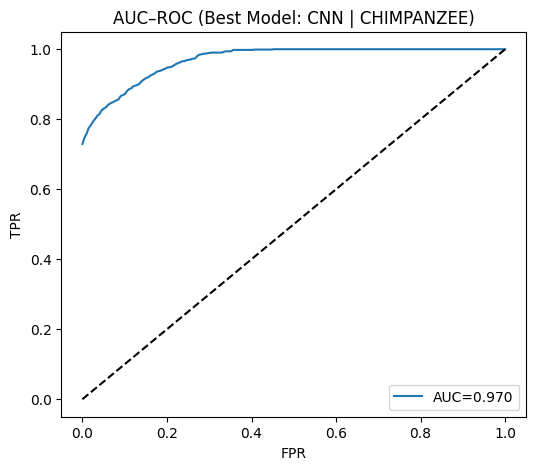


DATASET: HUMAN | ENCODING: KMER
HUMAN | 4380 samples | 7 classes

== STAGE 1: CONFIG SEARCH ==

CNN CONFIG RESULTS
CNN CONFIG 1 -> {'acc': 0.9098173515981736, 'prec': 0.9290801904579801, 'recall': 0.8898750553225405, 'f1': 0.9065252425089929, 'mcc': 0.8896553436409409, 'auc': 0.9904820067008231}
CNN CONFIG 2 -> {'acc': 0.9200913242009132, 'prec': 0.9428722504717647, 'recall': 0.8981908143237296, 'f1': 0.9164174826520697, 'mcc': 0.9026991403090056, 'auc': 0.9935586119457671}
CNN CONFIG 3 -> {'acc': 0.9098173515981736, 'prec': 0.9279167591092113, 'recall': 0.8870932277697123, 'f1': 0.9034762293082551, 'mcc': 0.889864479735918, 'auc': 0.9904027351321124}

CNN-Attention CONFIG RESULTS
CNN-Attention CONFIG 1 -> {'acc': 0.8538812785388128, 'prec': 0.8477272275858831, 'recall': 0.8414113633696468, 'f1': 0.8438421179957986, 'mcc': 0.8215424317829457, 'auc': 0.9656645663848576}
CNN-Attention CONFIG 2 -> {'acc': 0.8481735159817352, 'prec': 0.8293477168868714, 'recall': 0.8383775008749533, 'f1':

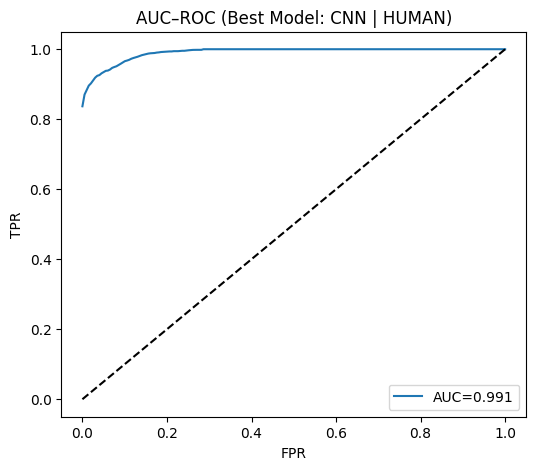


DATASET: DOG | ENCODING: KMER
DOG | 820 samples | 7 classes

== STAGE 1: CONFIG SEARCH ==

CNN CONFIG RESULTS
CNN CONFIG 1 -> {'acc': 0.49390243902439024, 'prec': 0.7883597883597885, 'recall': 0.35969303600882546, 'f1': 0.375106978275181, 'mcc': 0.3649429280255173, 'auc': 0.7400367350592587}
CNN CONFIG 2 -> {'acc': 0.49390243902439024, 'prec': 0.7131184116758149, 'recall': 0.38328834907782283, 'f1': 0.3859937299695232, 'mcc': 0.38175898299818467, 'auc': 0.7672533152232383}
CNN CONFIG 3 -> {'acc': 0.5304878048780488, 'prec': 0.8795947459525506, 'recall': 0.3878778141936037, 'f1': 0.4296052088891638, 'mcc': 0.44105612787381265, 'auc': 0.7849488401990176}

CNN-Attention CONFIG RESULTS
CNN-Attention CONFIG 1 -> {'acc': 0.49390243902439024, 'prec': 0.42552793475113626, 'recall': 0.37353212090054194, 'f1': 0.3738177090937905, 'mcc': 0.35779544984626516, 'auc': 0.6976213453838803}
CNN-Attention CONFIG 2 -> {'acc': 0.4695121951219512, 'prec': 0.43998144712430426, 'recall': 0.35456483088062035

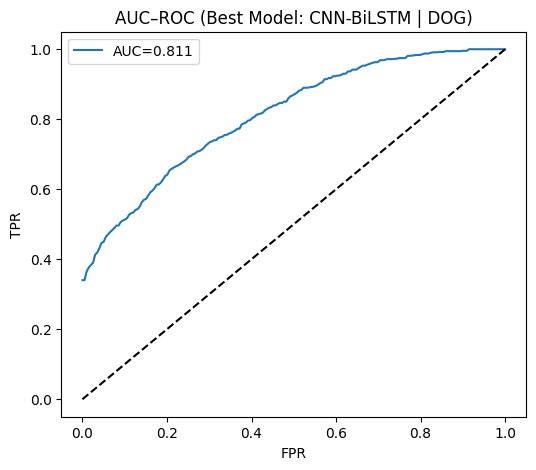

In [13]:
for d in ["chimpanzee","human","dog"]:
    run_pipeline(d)


CHIMPANZEE | 1682 samples | 7 classes
HUMAN | 4380 samples | 7 classes
DOG | 820 samples | 7 classes

DATASET: COMBINED | ENCODING: KMER
COMBINED | 6882 samples | 7 classes

== STAGE 1: CONFIG SEARCH ==

CNN CONFIG RESULTS
CNN CONFIG 1 -> {'acc': 0.9244734931009441, 'prec': 0.9452972805970595, 'recall': 0.9008437715633522, 'f1': 0.9205797370602337, 'mcc': 0.9078622229831723, 'auc': 0.9944030713127088}
CNN CONFIG 2 -> {'acc': 0.9295570079883806, 'prec': 0.9483795878415274, 'recall': 0.9115657957054616, 'f1': 0.9273744872211446, 'mcc': 0.9143373105770308, 'auc': 0.9944368585898621}
CNN CONFIG 3 -> {'acc': 0.9172113289760349, 'prec': 0.9178777156960888, 'recall': 0.9060486315467449, 'f1': 0.9086206708201555, 'mcc': 0.8995131501940506, 'auc': 0.9937614633627042}

CNN-Attention CONFIG RESULTS
CNN-Attention CONFIG 1 -> {'acc': 0.8634713144517067, 'prec': 0.8657106357148617, 'recall': 0.8476407828000422, 'f1': 0.8548849808846045, 'mcc': 0.8327845542084035, 'auc': 0.9722781715871059}
CNN-Atten

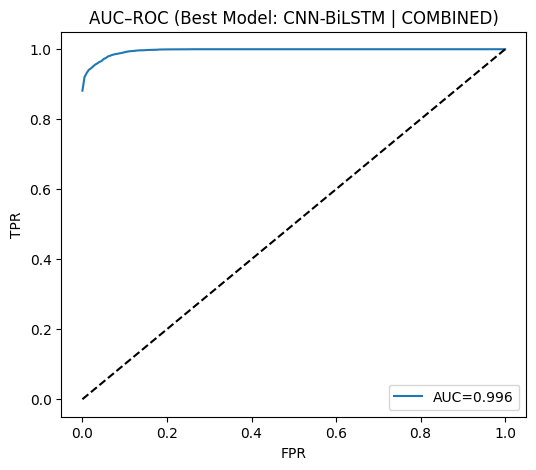

In [14]:
dfs=[]
for d in ["chimpanzee","human","dog"]:
    df,_=load_dataset(d)
    dfs.append(df)

combined = pd.concat(dfs)
combined.to_csv("combined.txt",sep="\t",index=False)
DATASETS["combined"]="combined.txt"

run_pipeline("combined")
